<a href="https://colab.research.google.com/github/pmckim1/NLP_News_Project/blob/main/Election_Week_NLP_Topic_with_BERT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with BERT: Election Week 

In [1]:
!pip install hdbscan
!pip install sentence_transformers
!pip install umap

     |████████████████████████████████| 4.7MB 17.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301794 sha256=1d02fcb8f9598f2a3a5814290a129b10dbcea6f3b05215647701c056e73e86e0
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 1.3MB 17.8MB/s 
     |████████████████████████████████| 2.9MB 50.0MB/s 
     |████████████████████████████████| 1.1MB 55.1MB/s 
     |████████████████████████████████| 890kB 47.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101035 sha256=dd47a810bcd3e7da640c4b096232002a2429351178a720a919a668ff32bbe7a5
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2

In [2]:
import numpy as np
import pandas as pd
import umap
import nltk
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Load data


In [3]:
import os
from google.colab import drive
import sys
import pandas as pd
import umap.umap_ as umap
import json
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/nlpproj/'

# dataset was cleaned in R has weeks 4 & 5: weeks around the US Election 
data_set = pd.read_csv(abspath_curr + 'eleweeks.csv', header=0)

data = data_set["text"].to_list()


Mounted at /content/drive


In [4]:
len(data_set)
data_set.tail()

,article number,headline,webPublicationDate,text,snippet,section,source,week
692,1962,"UK death toll from Covid-19 passes 50,000",11/11/20,"The UK’s Covid-19 death toll has surpassed 50,...",NaN,Foreign,Guardian,5
693,1963,UK government must condemn Trump denial of def...,11/11/20,The government should condemn Donald Trump’s r...,NaN,Politics,Guardian,5
694,1964,US Covid response must tie economic recovery t...,11/11/20,Politicians and officials leading the US respo...,NaN,Foreign,Guardian,5
695,1965,Vote Leave's Lee Cain tipped as next Downing S...,11/11/20,"One of Boris Johnson’s most loyal allies, Lee ...",NaN,Politics,Guardian,5
696,1966,‘We’re in power now’: Evo Morales makes gleefu...,11/11/20,Tens of thousands of jubilant followers have w...,NaN,Foreign,Guardian,5


## Create embeddings
Conver the documents to numerical data. We are modeling topics with **BERT** 

 

In [5]:
%%time
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data_set["text"], show_progress_bar=True)

100%|██████████| 245M/245M [00:20<00:00, 11.9MB/s]



CPU times: user 19.4 s, sys: 4.06 s, total: 23.5 s
Wall time: 50 s


## Reduce dimensionality
Use **UMAP** to reduce the dimensionality of the embeddings created for customized berttopic model mentioned above. It is important to keep a little bit of dimensionality as that allows the reduced embeddings to contain more structure to improve clustering at a later stage. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [6]:
%%time


umap_embeddings = umap.UMAP(n_neighbors=3,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings)
          

CPU times: user 6.47 s, sys: 193 ms, total: 6.66 s
Wall time: 6.54 s


## Cluster documents
Use **HDBSCAN** to find highly-densed clusters. **minimum cluster size** enables use to decrease the number of topics found and increase the topic sizes and vice-versa.  We want smaller localized clusters so use a very small number.  

In [7]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

CPU times: user 31.9 ms, sys: 0 ns, total: 31.9 ms
Wall time: 34.8 ms


## Visualize Clusters
Visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Gray are outliers

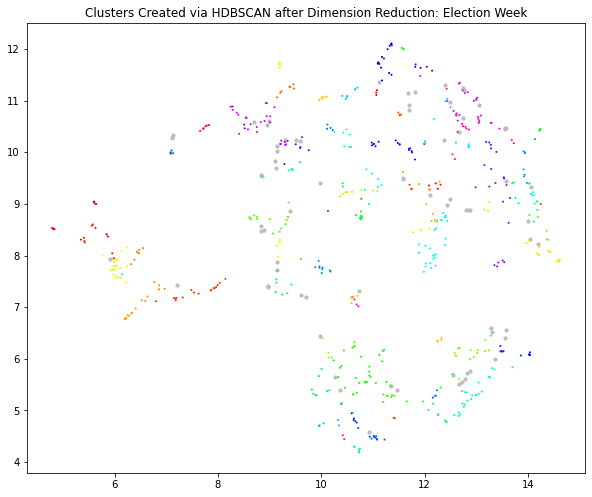

In [8]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=4, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='gist_rainbow')
#plt.colorbar()
ax.axis('scaled')
plt.title("Clusters Created via HDBSCAN after Dimension Reduction: Election Week")
import matplotlib.cm as cm
# plt.savefig("result1.png", dpi = 300)

## Prepare results
For easier selection, we put the results in a pandas dataframe. 

In [9]:

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print(docs_df)
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#print(docs_df["Topic"]==4)


                                                   Doc  Topic  Doc_ID
0     At age 42, Mehdy Belabbas embodied the French...      5       0
1     As coronavirus cases have shot through the ro...     -1       1
2    The United States is embroiled in a bitter pre...     40       2
3    Joseph R. Biden Jr. holds a small but durable ...     34       3
4     President Trump’s campaign in the crucial bat...     23       4
..                                                 ...    ...     ...
692  The UK’s Covid-19 death toll has surpassed 50,...     66     692
693  The government should condemn Donald Trump’s r...     41     693
694  Politicians and officials leading the US respo...     52     694
695  One of Boris Johnson’s most loyal allies, Lee ...     30     695
696  Tens of thousands of jubilant followers have w...     29     696

[697 rows x 3 columns]


## Calculate word importance per topic
Calculate the importance of words in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then, extract the words with the highest values in each cluster as a representative of a topic.  

In [10]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))

In [11]:
# n= how many words to return 
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,76
6,5,16
20,19,16
31,30,15
16,15,14
34,33,14
46,45,14
47,46,14
41,40,14
42,41,13


In [12]:
#print length of orignal topics returned 
print(len(topic_sizes))

79


In [13]:
# print top words assocated with clusters 
print(top_n_words)

{-1: [('rabin', 0.005886947907168597), ('dogs', 0.0036166213854303257), ('peace', 0.0029878123678266093), ('ehrc', 0.0027341945446862285), ('cummings', 0.0027079960372975546), ('law', 0.002662188024314247), ('masks', 0.002505496824511076), ('interference', 0.0024700503069822427), ('elephants', 0.0024447311259287565), ('security', 0.0023686639128269126), ('french', 0.0023463679465821263), ('macron', 0.0023370808633802823), ('durham', 0.002286592542786246), ('second', 0.0022548897869072433), ('things', 0.0022328683320396183), ('face', 0.0022223086073936927), ('prime', 0.002202643605057623), ('groups', 0.0021845494675074967), ('duong', 0.0021781457293623325), ('local', 0.0021584677281711252)], 0: [('storms', 0.05916656526145571), ('hurricane', 0.05916656526145571), ('eta', 0.051272908281193734), ('nicaragua', 0.04568186047954103), ('storm', 0.04534245679815455), ('flooding', 0.04187503877291261), ('honduras', 0.03977694768290982), ('hurricanes', 0.030183811463857988), ('puerto', 0.0293077

## Topic Reduction
reduce the topics using class based tf_idf so that related clusters are combined 

In [14]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


,Topic,Size
0,-1,126
14,13,23
33,32,18
5,4,16
10,9,16
18,17,16
2,1,15
46,45,15
42,41,15
26,25,15


In [15]:
# print length of topics after reduction 

#print top words for each cluster 
print(len(topic_sizes))

# print topics for single cluster
print(json.dumps(top_n_words[13], indent=1))

#print top words for each cluster 
for key, value in top_n_words.items():
  print(key, ' : ', value)

59
[
 [
  "corbyn",
  0.02240343816823932
 ],
 [
  "antisemitism",
  0.01799626503846685
 ],
 [
  "jeremy",
  0.013922247233702745
 ],
 [
  "ehrc",
  0.012622377361450849
 ],
 [
  "starmer",
  0.012453622394948977
 ],
 [
  "suspension",
  0.012181017349184016
 ],
 [
  "report",
  0.010658747756127542
 ],
 [
  "labour",
  0.010492347447324761
 ],
 [
  "complaints",
  0.008589582364436032
 ],
 [
  "jewish",
  0.008127330331812442
 ]
]
-1  :  [('rabin', 0.0034710858236929594), ('ardern', 0.002721510092543786), ('zealand', 0.0026758807519695255), ('care', 0.0023589860141360174), ('hospital', 0.0023589860141360174), ('women', 0.0023461403046852445), ('says', 0.002282049813896946), ('wave', 0.002198174528780194), ('second', 0.00215736217636674), ('patients', 0.002138057089618947)]
0  :  [('storms', 0.05916656526145571), ('hurricane', 0.05916656526145571), ('eta', 0.051272908281193734), ('nicaragua', 0.04568186047954103), ('storm', 0.04534245679815455), ('flooding', 0.04187503877291261), ('ho